# Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lazzaronico/cytobench/blob/main/2%20library%20overview.ipynb)  

Execute the following cells if you are running the notebook from Google Colab

In [ ]:
# clone the cytobench repository to access required files
!git clone https://github.com/lazzaronico/cytobench/
%cd cytobench

In [ ]:
# install missing libraries
!pip install -r requirements.txt

# Libraries

In [1]:
# computing libraries
import numpy as np
import pandas as pd

# tensorflow libraries
import tensorflow as tf
import tensorflow_probability as tfp

# sklearn for pca plotting
import sklearn.decomposition

# single cell data object
import anndata

# friendliest benchmarking library in the village
import cytobench

# graphic libraries
import seaborn as sns
import matplotlib.pyplot as plt

# default figures style
sns.set(style='whitegrid')

# figures box size
figsize = 6

# Data loading

We will explore some of the library main functions using a mini version of Tabula Muris, one of the most important reference datasets for mouse biology. In this subset of the original dataset we have selected the 128 genes with the highest variance, and it's intended as a demo to showcase the library on Google Colab and low end laptops; for any meaningful analysis at least the top ~2k genes should be considered for reference (with the full dataset clocking at over 20k dimensions).

In [2]:
# select dataset to train/test model on
dataset = anndata.read_h5ad('datasets/mm-tabula-muris-droplet-128.h5ad')

# merge a few epithelial subtypes for plotting simplicity
dataset.obs['cell_ontology_class'].replace(
    ['keratinocyte', 'basal cell of epidermis', 'epithelial cell'],
    'epithelial cell',
    inplace=True
)

dataset

AnnData object with n_obs × n_vars = 45602 × 128
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [3]:
# extract count matrix and cells metadata for simplicity
X, metadata = dataset.X.toarray(), dataset.obs
X.shape, len(metadata)

((45602, 128), 45602)

In [4]:
# example info we have for the cells
metadata.head()

,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,tissue_free_annotation
index,,,,,,,,,,,,
10X_P4_0_AAACCTGAGATTACCC-1,3m,10X_P4_0_AAACCTGAGATTACCC,epithelial cell,CL:0002187,suprabasal differentiating,droplet,3-M-8,NaN,male,nan,Tongue,Tongue
10X_P4_0_AAACCTGAGTGCCAGA-1,3m,10X_P4_0_AAACCTGAGTGCCAGA,epithelial cell,CL:0000312,suprabasal differentiating,droplet,3-M-8,NaN,male,nan,Tongue,Tongue
10X_P4_0_AAACCTGCAAATCCGT-1,3m,10X_P4_0_AAACCTGCAAATCCGT,epithelial cell,CL:0000312,suprabasal,droplet,3-M-8,NaN,male,nan,Tongue,Tongue
10X_P4_0_AAACCTGGTAATCGTC-1,3m,10X_P4_0_AAACCTGGTAATCGTC,epithelial cell,CL:0002187,basal cell,droplet,3-M-8,NaN,male,nan,Tongue,Tongue
10X_P4_0_AAACCTGGTCCAACTA-1,3m,10X_P4_0_AAACCTGGTCCAACTA,epithelial cell,CL:0002187,proliferating,droplet,3-M-8,NaN,male,nan,Tongue,Tongue


# Model definition

In this notebook we will use a very simple VAE to learn the dataset distribution

In [7]:
# implement a simple variational autoencoder leveraging tfp for simplicity
class VAE(tf.keras.Model):
    def __init__(self, input_dim, layers_units, kl_loss_factor, learning_rate=1e-3):
        super(VAE, self).__init__()
        
        # check layers and initialize shorthand variables
        assert len(layers_units) >= 1, "VAE expects at least 1 layer"
        hidden_layers, latent_dim = layers_units[:-1], layers_units[-1]
        
        # actual size of bottleneck for given distribution and latent space dimension
        dist_params_size = tfp.layers.IndependentNormal.params_size(latent_dim)
        
        # prior distribution for kl divergence
        prior = tfp.distributions.Independent(
            tfp.distributions.Normal(
                loc = tf.zeros(latent_dim), 
                scale = tf.ones(latent_dim)
            ), reinterpreted_batch_ndims = 1
        )
        
        # encoder
        self.encoder = tf.keras.Sequential([ 
            
            # input layer and log(1+x) stateless scaling
            tf.keras.layers.InputLayer(input_shape=(input_dim,)), 
            tf.keras.layers.Lambda(tf.math.log1p),

            # hidden layers
            *[ tf.keras.layers.Dense(units, activation='relu') for units in hidden_layers ],

            # embedding layer and kl divergence layer for loss wrt prior
            tf.keras.layers.Dense(dist_params_size, activation='linear'), 
            tfp.layers.IndependentNormal(latent_dim),
            tfp.layers.KLDivergenceAddLoss(prior, weight=kl_loss_factor),
            
        ])
        
        # decoder
        self.decoder = tf.keras.Sequential([
            
            # hidden layers
            *[ tf.keras.layers.Dense(units, activation='relu') for units in hidden_layers[::-1] ],
            
            # output layer and exp(x)-1 stateless scaling
            tf.keras.layers.Dense(input_dim, activation='relu'), 
            tf.keras.layers.Lambda(tf.math.expm1),
            
        ])

        # compile the model
        self.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate), loss=tf.keras.losses.MeanSquaredError())

    def call(self, inputs):
        return self.decoder(self.encoder(inputs).sample())

In [6]:
# initialize a basic Variational Autoencoder with 8 bottleneck units
model = VAE(input_dim = X.shape[1], layers_units = [64, 16, 4], kl_loss_factor = 1e-2)

# train using 60/40 train/validation split
training_mask = np.random.rand(len(X)) < 0.6

# train model
training_history = model.fit(
    X[training_mask], X[training_mask], epochs=5, batch_size=32, shuffle=True,
    validation_data=(X[~training_mask], X[~training_mask]),
)

Metal device set to: Apple M2 Max
Epoch 1/5


2024-09-19 09:58:46.126717: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


861/861 [==============================] - 8s 8ms/step - loss: 2.0861 - val_loss: 1.4957
Epoch 2/5
861/861 [==============================] - 7s 8ms/step - loss: 1.2644 - val_loss: 1.1496
Epoch 3/5
861/861 [==============================] - 7s 8ms/step - loss: 1.0365 - val_loss: 0.9988
Epoch 4/5
861/861 [==============================] - 7s 8ms/step - loss: 0.9092 - val_loss: 0.8757
Epoch 5/5
861/861 [==============================] - 7s 8ms/step - loss: 0.8538 - val_loss: 0.8436


# Model validation

Let's look at how well the model has learned the target dataset by focusing on a subset of it (comprised of epithelial cells) and tasking the model to reproduce the full distribution starting from a subset

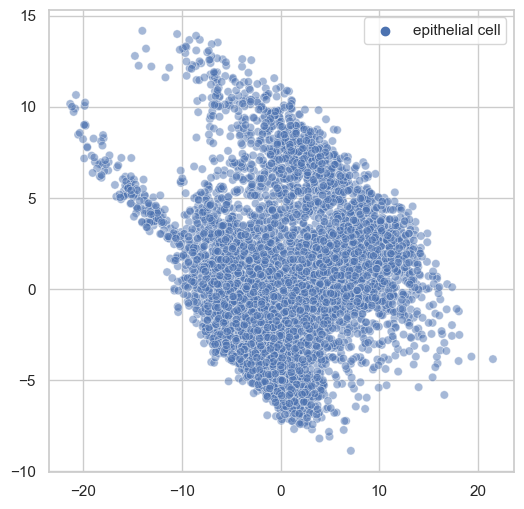

In [7]:
# select a subset of the full dataset comprised of different epithelial cells subtypes
cells_mask = metadata['cell_ontology_class'].isin(['epithelial cell'])
cells_labels = np.array(metadata['cell_ontology_class'].values[cells_mask])

# fit a PCA for plotting
pca_model = sklearn.decomposition.PCA(n_components=2)
cells_pca = pca_model.fit_transform(X[cells_mask])

# display selected population distribution in 2d
plt.figure(figsize=(figsize, figsize))
sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, hue=cells_labels)
plt.show()

A simple way to evaluate how our model has learned the empirical distribution is to sample some cells with repetition and then task the VAE to expand the sample (ie. simulate the system dynamics via Markov Chain Monte Carlo simulation)  
Below are displayed the centroids selected (with repetition) by Cytobench to begin the MCMC simulation  
Note: we start from a set of centroids and not randomly picked points in order to minimize the variance in the algorithm scoring (which is in turn necessary to minimize the number of bootstraps required)

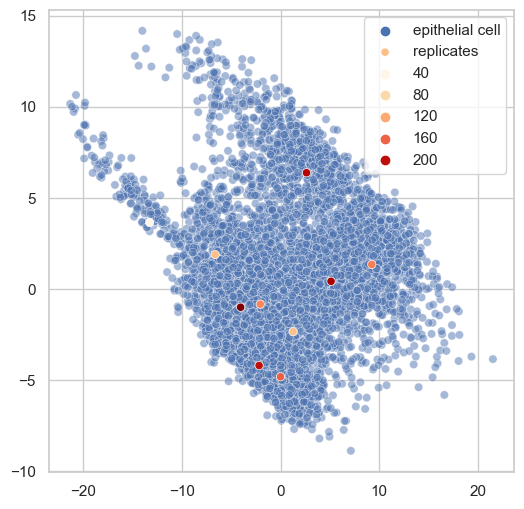

In [8]:
# fit cytobench coverage estimator using only 20% of all the points for speedup
coverage_estimator = cytobench.CoverageEstimator(approx_p=.2)
coverage_estimator.fit(X[cells_mask])

# extract initial cells population for MCMC validation, representing centroids of leiden clusters
initial_cells_pca = pca_model.transform(coverage_estimator.reference_points[coverage_estimator.centroids_repeats > 0])
initial_cells_replicates = coverage_estimator.centroids_repeats[coverage_estimator.centroids_repeats > 0]

# overlap initial centroids with pca, coloring by repetitions
plt.figure(figsize=(figsize, figsize))
sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, hue=cells_labels)
sns.scatterplot(x=initial_cells_pca[:,0], y=initial_cells_pca[:,1], hue=initial_cells_replicates, palette='OrRd')
plt.show()

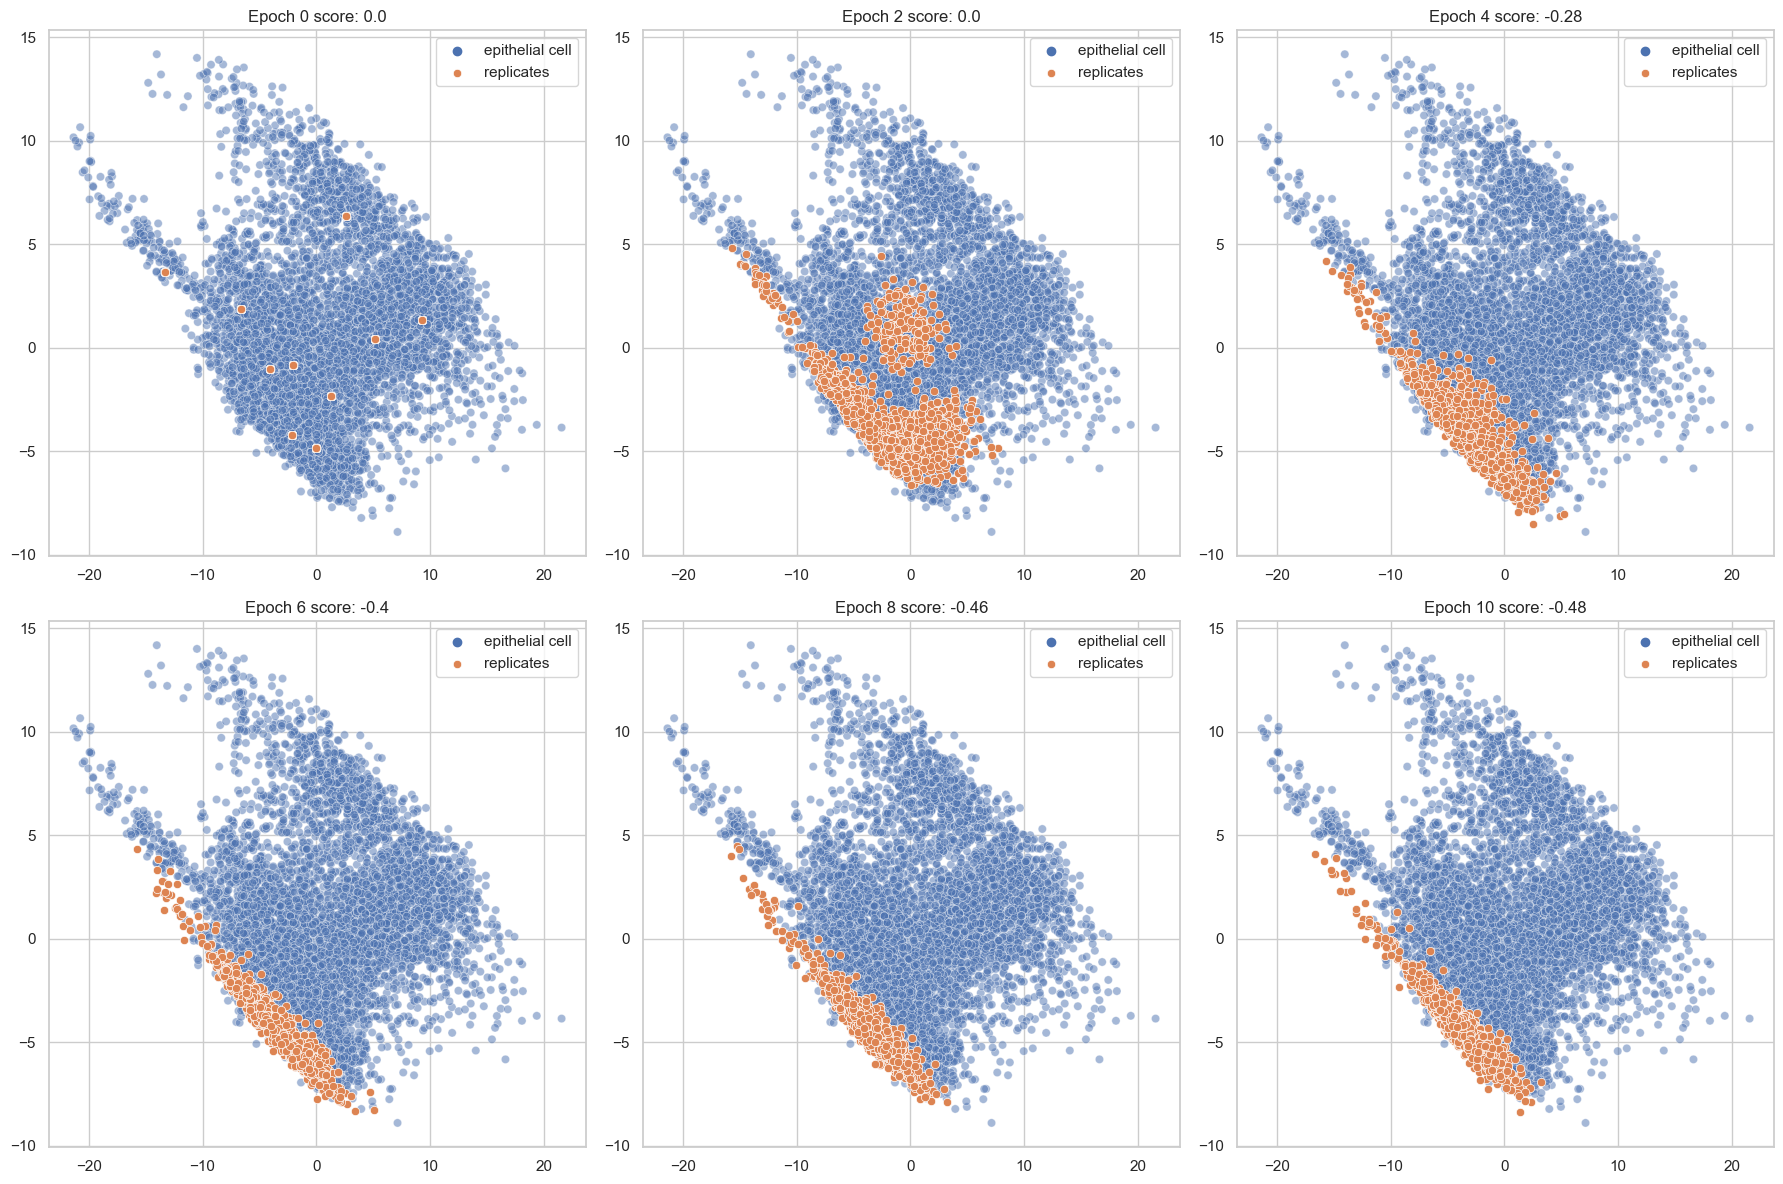

In [9]:
# initial population to be expanded
expanded_population = np.copy(coverage_estimator.initial_points)

# gather score of initial population with respect to the reference empirical distribution

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

for i in range(12):
    
    if i % 2 == 0:

        expanded_population_pca = pca_model.transform(expanded_population)

        sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, hue=cells_labels, ax=axes[i//2])
        sns.scatterplot(x=expanded_population_pca[:,0], y=expanded_population_pca[:,1], label='replicates', ax=axes[i//2])
        
        axes[i//2].set_title(f'Epoch {i} score: {np.round(coverage_estimator.score(expanded_population), 2)}')
    
    # sample a new population by passing it through the VAE
    expanded_population = model.decoder(model.encoder(expanded_population))

plt.tight_layout()  # Adjust layout so plots don't overlap
plt.show()

In this case the model seems to have learned poorly the underlying manifold, as the sampled distribution never ameliorates the original one  
This could be addressed by working on the training pipeline for this toy example, but in real datasets (with tens of thousands of dimensions) this will often be unavoidable with basic architectures  
A simple way to ameliorate the predictions is to remove the encoder bias by considering only the effect resulting from moving in the learned manifold (effector sampling)  

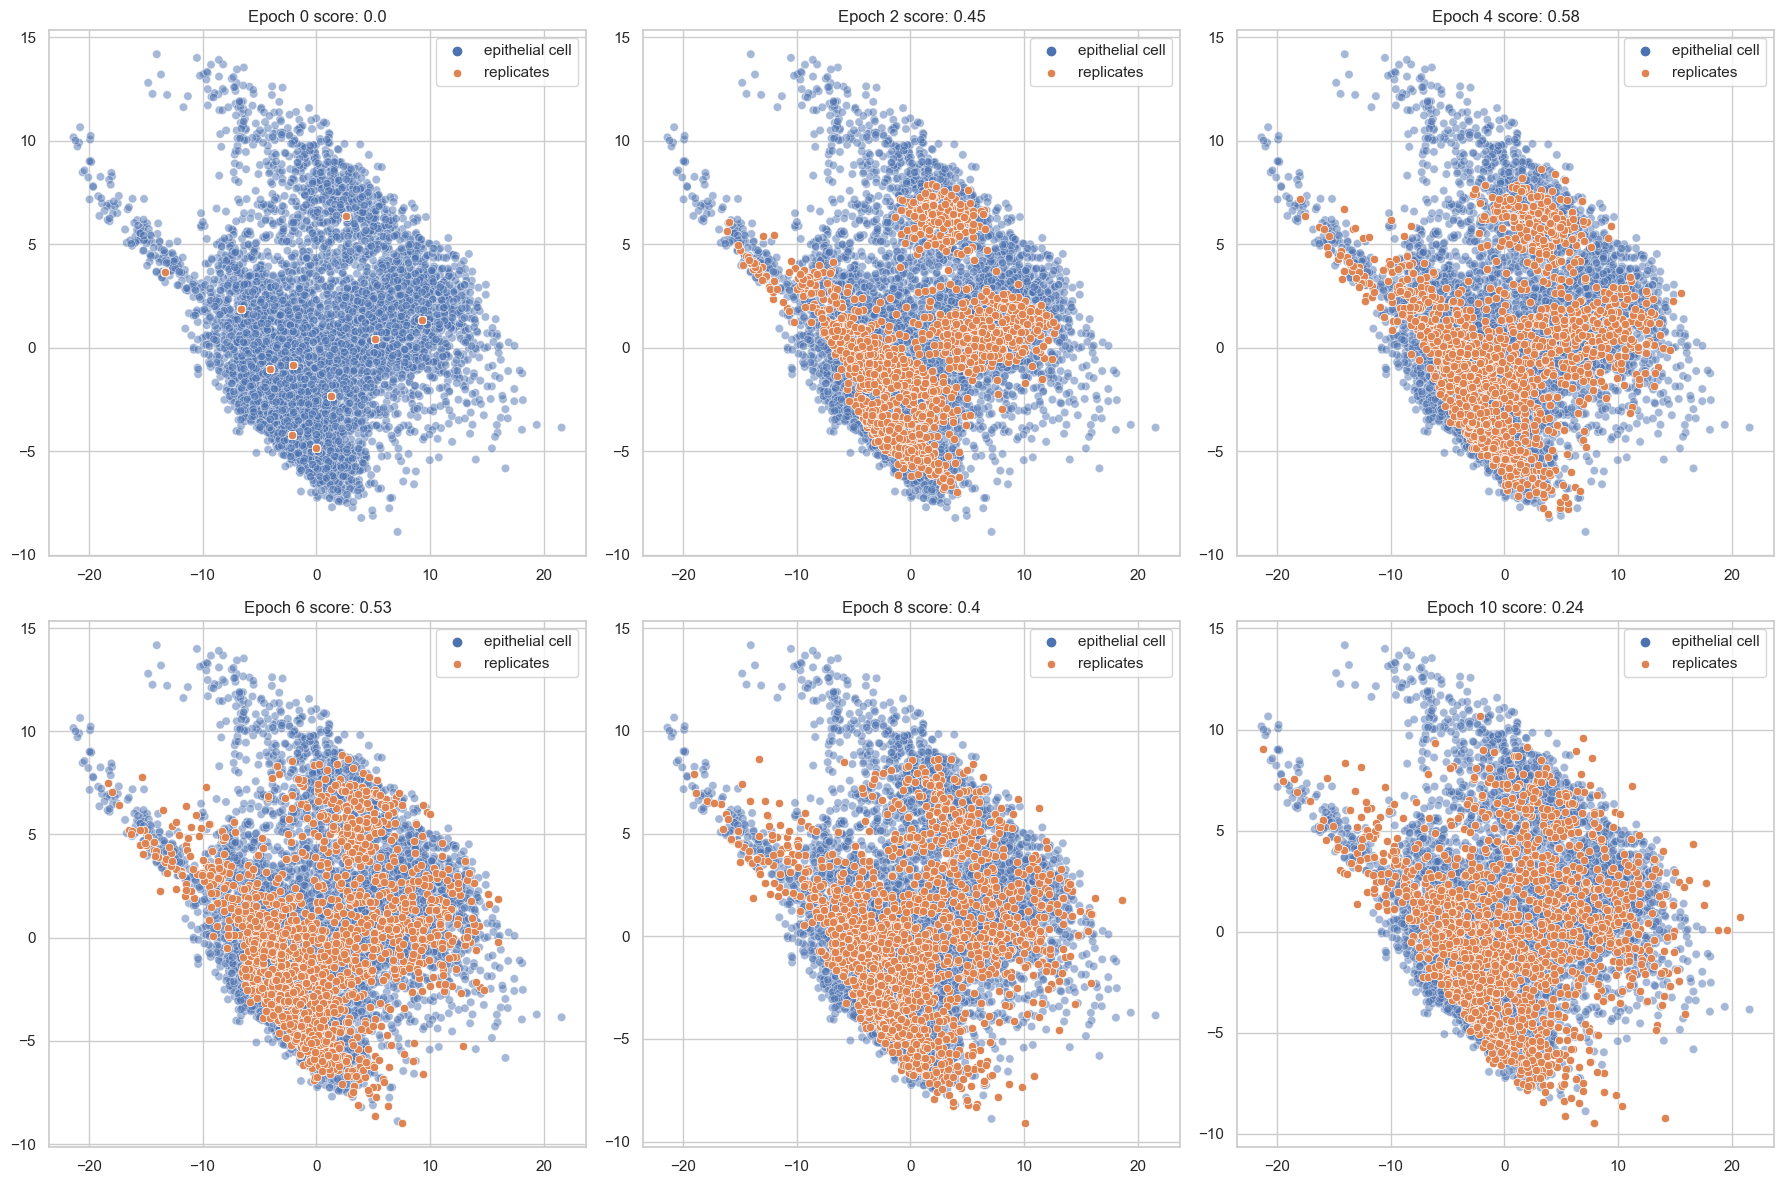

In [10]:
# effector sampling approach: remove the bias component originating from the encoding process itself
def sample_fn(X):
    
    # project into the manifold
    z = model.encoder(X)
    
    # consider the effect in the real space attributed by moving in the manifold
    delta = model.decoder(z) - model.decoder(z.mean())
    
    # ReLU the reads to keep them in the scRNA space
    return np.maximum(0, X + delta)

# initial population to be expanded
expanded_population = np.copy(coverage_estimator.initial_points)

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

for i in range(12):
    
    if i % 2 == 0:

        expanded_population_pca = pca_model.transform(expanded_population)

        sns.scatterplot(x=cells_pca[:,0], y=cells_pca[:,1], alpha=.5, hue=cells_labels, ax=axes[i//2])
        sns.scatterplot(x=expanded_population_pca[:,0], y=expanded_population_pca[:,1], label='replicates', ax=axes[i//2])
        
        axes[i//2].set_title(f'Epoch {i} score: {np.round(coverage_estimator.score(expanded_population), 2)}')
    
    # sample a new population by passing it through the VAE
    expanded_population = sample_fn(expanded_population)

plt.tight_layout()
plt.show()

The cytobench score is by default regularized in the interval \[+1, -1\], with 0 being the distance of the initial samples wrt the empirical reference distribution, +1 being a perfect match with the reference and -1 the opposite  
In this case it seems to be matching somewhat accurately the qualitative intuition we might have of the expanding population accuracy with respect to the underlying empirical distribution  
We can leverage cytobench scoring pipeline to repeat the scoring process automatically for a number of repetitions, plotting a confidence interval for the process  
Keep in mind that the score will be highly affected by the set of initial samples (in case of MCMC simulations); for this reason when comparing models its of paramount importance to always operate from the same initial conditions

Note: here we are using only a portion of the full dataset, which will be a common usecase for preliminary validation of models in large datasets as the evaluation complexity in general scales quadratically with the number of empirical samples

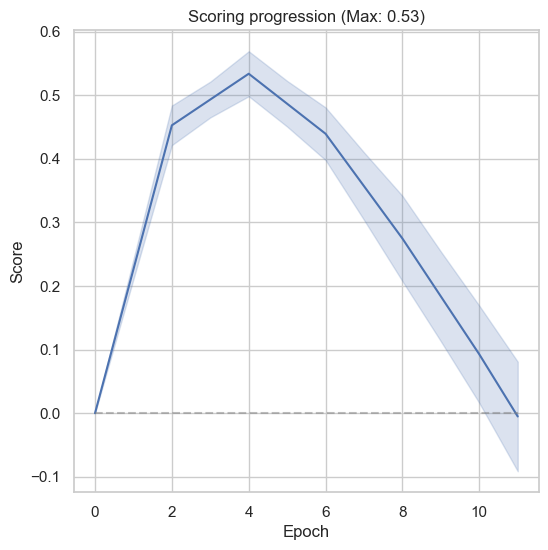

In [11]:
# bootstrap the scoring pipeline 5 times, computing score on 20% of the considered data
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p=.2, n_iterations=12, score_every_n=2)
    for i in range(5)
])

# import to dataframe for ease of plotting
df = pd.DataFrame(scores).melt(var_name='Epoch', value_name='Score')

# lineplot with sd and highlight null score
plt.figure(figsize=(figsize, figsize))
sns.lineplot(data=df, x='Epoch', y='Score', errorbar='sd')
plt.hlines(0, 0, df['Epoch'].max(), color='grey', alpha=.5, linestyles='--')

plt.title(f'Scoring progression (Max: {np.round(scores.mean(axis=0).max(), 2)})')
plt.show()

We can easily validate other sampling approaches tweaking the sampling function  
Eg. we might be interested in havin the model expand the underlying population a little slower before degrading to have more control over it when applying the model to an external dataset (although for VAE it might be more beneficial to have this directly factored in the model training)

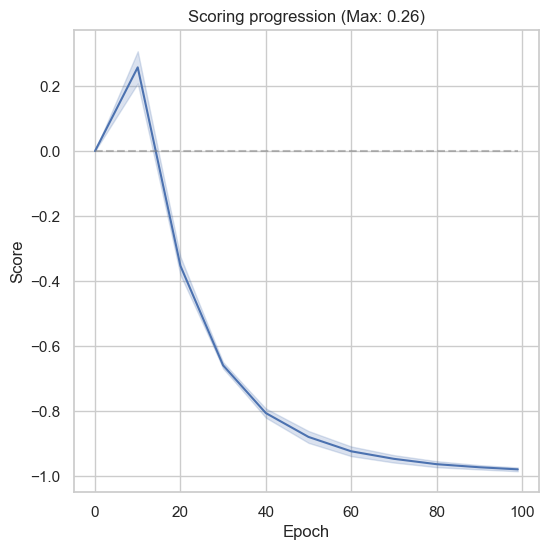

In [12]:
# refactor the sampling function to accept a scaling factor for moving in the latent space
def sample_fn(X, scale_factor = .9):
    
    # gather distribution params
    z = model.encoder(X)
    
    # sample new points, considering a scaled version of the network std
    z1 = np.random.normal(loc=z.mean(), scale=z.stddev() * scale_factor)
    
    # compute effective delta
    delta = model.decoder(z1) - model.decoder(z.mean())
    
    # return positive component
    return np.maximum(0, X + delta)

# bootstrap the scoring pipeline 5 times
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p=.2, n_iterations=100, score_every_n=10)
    for i in range(5)
])

# import to dataframe for ease of plotting
df = pd.DataFrame(scores).melt(var_name='Epoch', value_name='Score')

# lineplot with sd and highlight null score
plt.figure(figsize=(figsize, figsize))
sns.lineplot(data=df, x='Epoch', y='Score', errorbar='sd')
plt.hlines(0, 0, df['Epoch'].max(), color='grey', alpha=.5, linestyles='--')

plt.title(f'Scoring progression (Max: {np.round(scores.mean(axis=0).max(), 2)})')
plt.show()

# Score multiplexing

Since we gather the initial points from an explicit set of clusters and then evaluate the expansion with respect to the whole reference set, we can track for free the local performances by isolating the relevant terms from the global pairwise distance matrix  
Cytobench implements this logic by default and allows for transparent access to the individual groups evaluations, with the entire set being considered as a cluster on its own (comprised of the union of all other sets)  
The leiden resolution parameter can be adjusted to increase difficulty of the expansion process (by lowering the resolution)  
Here we show how the dataset above was mapped locally, and how the individual neighbourhoods score progressed through the epochs

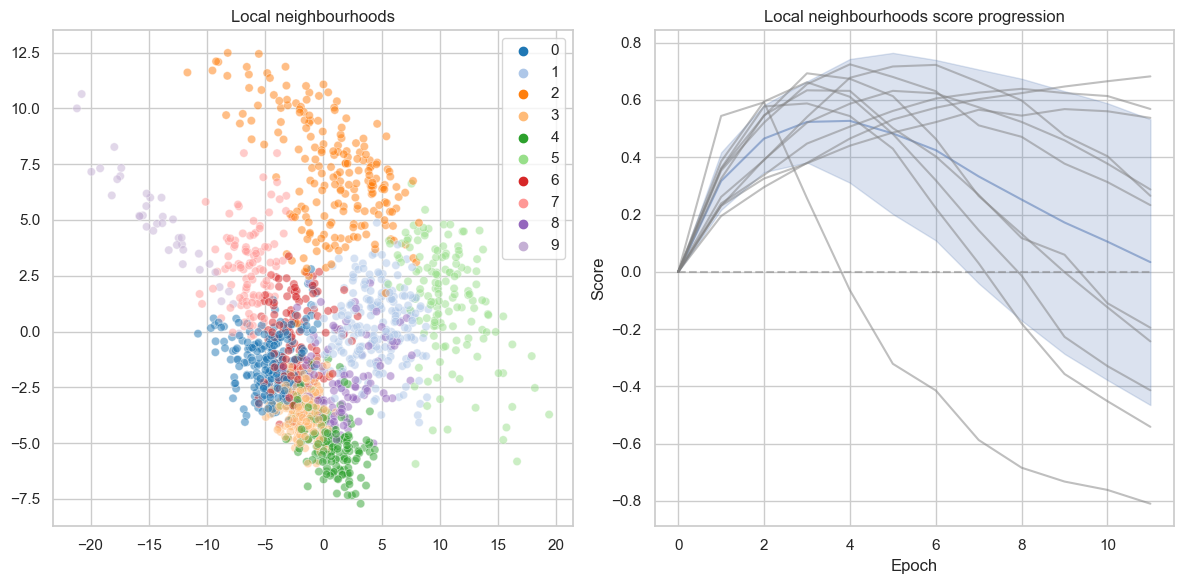

In [13]:
# vanilla effector sampling
def sample_fn(X):
    z = model.encoder(X)
    return np.maximum(0, X + model.decoder(z) - model.decoder(z.mean()))

# score once, registering all neighbourhood scores rather than only the global one
expanded_population = np.copy(coverage_estimator.initial_points)

scores, n_episodes = [], 12

# gather score of initial population with respect to the reference empirical distribution
for i in range(n_episodes):
    
    # scoring without aggregating returns the individual components of the global score
    scores.append(coverage_estimator.score(expanded_population, aggregate=False))
    
    # sample new population
    expanded_population = sample_fn(expanded_population)
    
# store scores for future reference
scores = np.array(scores)

# convert to dataframe for ease of plotting
df = pd.DataFrame(scores)
df['Epoch'] = range(n_episodes)
df = df.melt(id_vars='Epoch', var_name='neighbourhood', value_name='Score')

# plot the leiden clustering happening under the hood and the local score progression
fig, axes = plt.subplots(1, 2, figsize=(figsize*2, figsize))

# in this case we must consider only the reference subset
cells_subset_pca = pca_model.transform(coverage_estimator.reference_points)
sns.scatterplot(x=cells_subset_pca[:,0], y=cells_subset_pca[:,1], alpha=.5, hue=coverage_estimator.labels, palette='tab20', ax=axes[0])

axes[0].set_title('Local neighbourhoods')

# plot global score trend
sns.lineplot(data=df, x='Epoch', y='Score', errorbar='sd', color='#4c72b0', ax=axes[1], alpha=.5)
axes[1].hlines(0, 0, df['Epoch'].max(), color='grey', alpha=.5, linestyles='--')

# plot local scores
for n in df['neighbourhood'].unique():
    sns.lineplot(data=df[df['neighbourhood']==n], x='Epoch', y='Score', color='grey', alpha=.5, label=None, ax=axes[1])

axes[1].set_title('Local neighbourhoods score progression')

# use clusters to track performance across cell types
plt.tight_layout()
plt.show()

By default Cytobench returns a "balanced" score, which is equal to the score of every neighbourhood weighted by the number of samples in it, including the "global" neighbourhood (which will then account for 50% of the total score)  
If we'd like instead to consider every neighbourhood as having the same weight we can set the scoring scope to "equal"

In [14]:
# we can access the weights of each neighbourhood directly from the PED estimator
coverage_estimator.subsets_weights

array([0.5       , 0.03446034, 0.06501951, 0.06892068, 0.06664499,
       0.04486346, 0.01235371, 0.03381014, 0.07509753, 0.0523407 ,
       0.04648895])

You can easily access the local neighbourhoods score in order to do arbitrary computations and statistical analysis

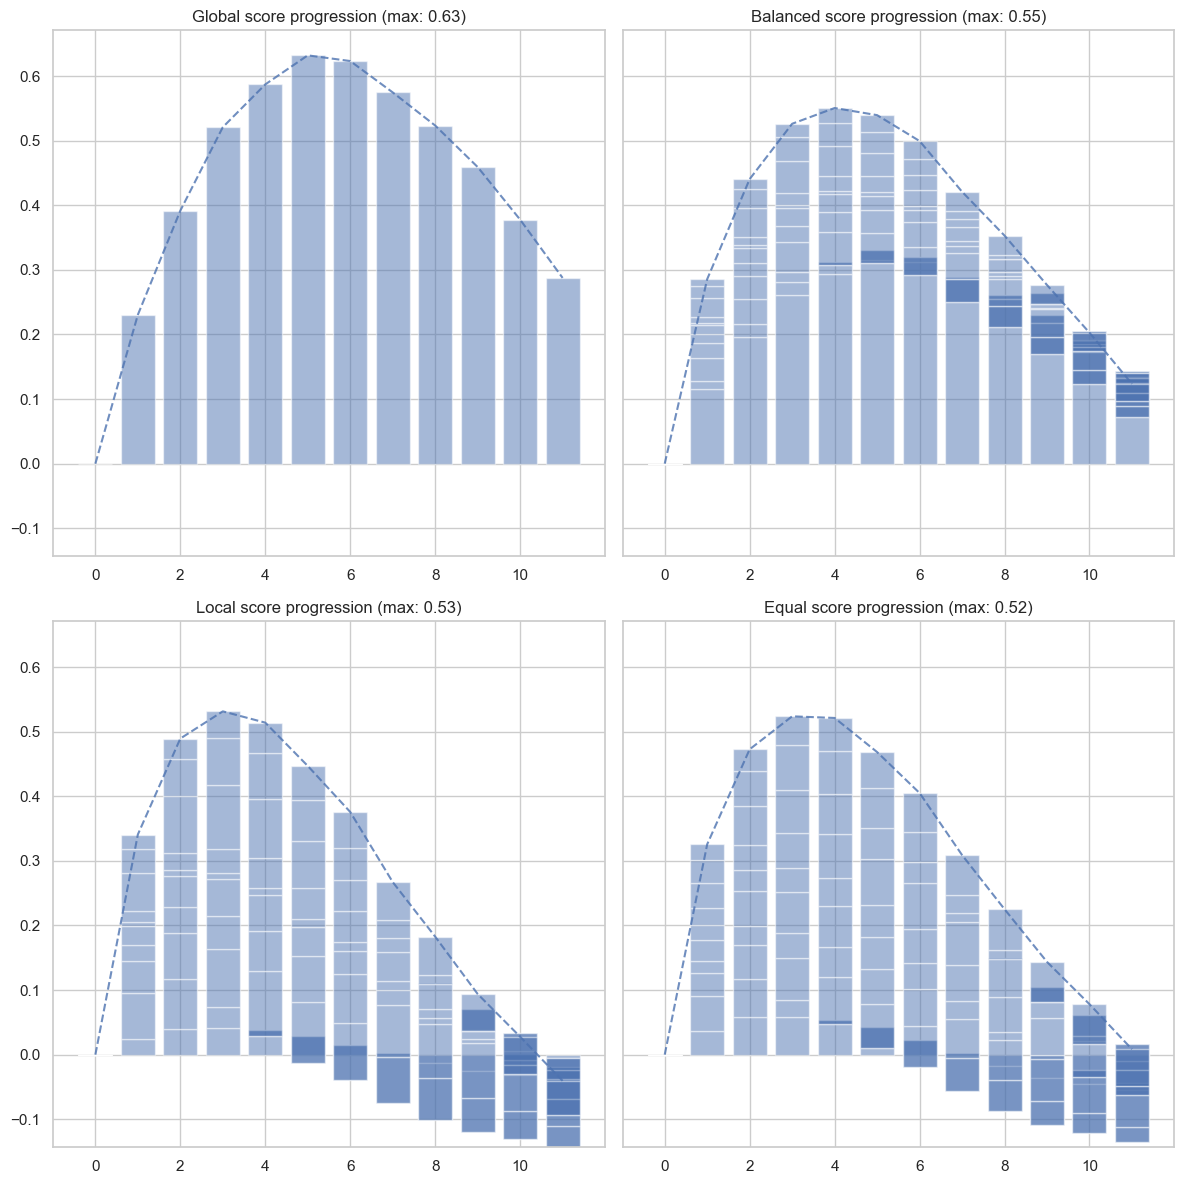

In [16]:
def plot_scores(scores, plot_grid = (2, 2), scopes = ['Global', 'Balanced', 'Local', 'Equal'], max_score=False):

    # compute the weighted scores for simplicity
    wscores = scores * coverage_estimator.subsets_weights

    # extract how the scores would have been in the different methods
    score_progression = [

        # global = consider all samples as a single cluster
        ('Global', [ wscores[:, 0] * 2 ]),

        # balanced = consider local and global clusters, each one weighted by its number 
        ('Balanced', [ wscore for wscore in wscores.T ]),

        # local = like balanced but without taking into consideration the global cluster
        ('Local', [ wscore * 2 for wscore in wscores.T[1:] ]),

        # equal = like local but without weighting each cluster with its numerosity
        ('Equal', [ score for score in (scores / (scores.shape[1]-1)).T[1:] ]),
    ]
    
    # keep only specified methods
    filtered_score_progression = filter(lambda v: v[0] in scopes, score_progression)
    
    # setup plots grid 
    fig, axes = plt.subplots(plot_grid[0], plot_grid[1], figsize=(figsize*plot_grid[1], figsize*plot_grid[0]), sharey=True)
    axes = axes.flatten()

    # plot every score progression
    for i, (score_name, score_values) in enumerate(filtered_score_progression):

        bottom = np.zeros(len(scores))

        for j, sv in enumerate(score_values):
            
            if max_score:
                sv = np.maximum.accumulate(sv)
            
            axes[i].bar(np.arange(len(scores)), sv, bottom=bottom, color='#4c72b0', alpha=.5)
            bottom += sv

        axes[i].plot(np.arange(len(scores)), bottom, label='Effective Score', color='#4c72b0', linestyle='--', alpha=.8)
        axes[i].set_title(f'{score_name} score progression (max: {max(bottom):.2f})')

    plt.tight_layout()
    plt.show()
    
# plot current run
plot_scores(scores, (2,2))

In general you might be interested in gathering the maximum score obtained by a generative model with respect to all neighbourhoods, which you can do either by running the scoring pipeline manually for every cluster or by extracting the information from a standard run (especially if you're gathering the global score, which will let you have all the locals for free)  
This approach can be particularly useful for large dataset with a wide range of cell types and local manifold characteristics  
Notice the difference in maximum scores attainable by the weighted and equal scoring approaches

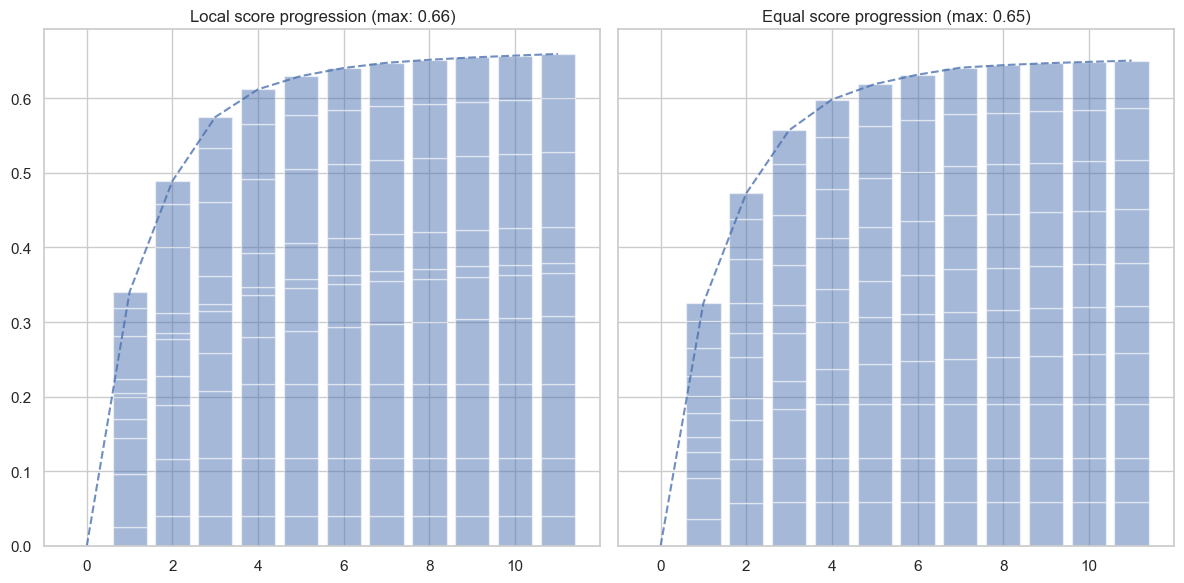

In [17]:
# plot current run
plot_scores(scores, (1,2), scopes=['Local', 'Equal'], max_score=True)


Following is an example of scoring pipeline considering a couple of different cell types, showcasing the initial clusters considered for centroids selection and the difference in score progression for the two manifold volumes  
Note: trying this in the original dataset will unveil a much more significant differential

# Leveraging null distributions

One can trivially leverage the PED to yield a pvalue for a candidate distribution by relying on local CDFs (as showcased in the introductory notebook), but this is in general less informative than using the score above and of little use in practice. Even when developing pure generative models in non-Markovian applications you should in general avoid relying on the pvalue when prototyping models.

One thing in which estimating the local null distribution is useful (and in fact recommended) is to evaluate a realistic minimum distance with respect to the reference distribution. The default setting is not using any (in order to make computations faster), assuming that the minimum achievable distance is 0. This is not only unrealistic, but doesn't take into account the different volume forms and density functions across the manifold. In general using the 50% quantile as ideal target is enough to account for differences in the metric tensors realized in different regions of the biological manifold, however a higher threshold (eg. 95%) can be used to validate a model capabilities of recapitulating distributions sufficiently for practical applications (targeting in this case a full score).

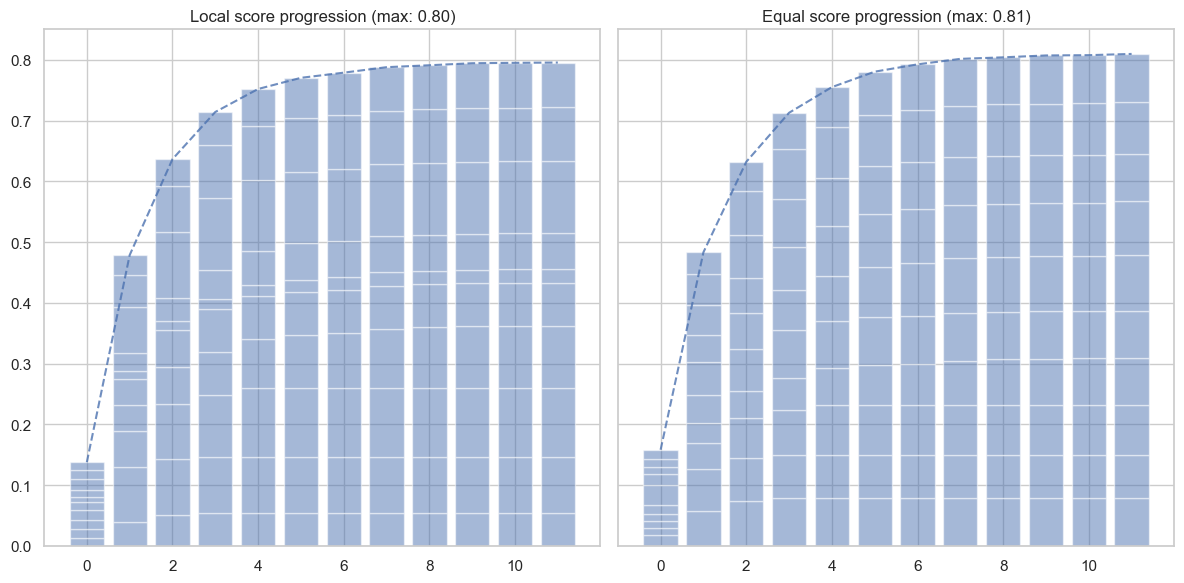

In [18]:
# we can automatically compute the adjusted minimum at fit time using min_dist_q = quantile in the coverage estimator
# in this case we just call set_min_q to .5, which will automatically compute the null distribution and adjust the minimum distance
coverage_estimator.set_min_q(.5)

# initialize cell population to expand and score array
expanded_population, scores = np.copy(coverage_estimator.initial_points), np.zeros((12, len(coverage_estimator.subsets)))

for i in range(len(scores)):
    scores[i] = coverage_estimator.score(expanded_population, aggregate=False)
    expanded_population = sample_fn(expanded_population)

# plot scores
plot_scores(scores, (1,2), scopes=['Local', 'Equal'], max_score=True)

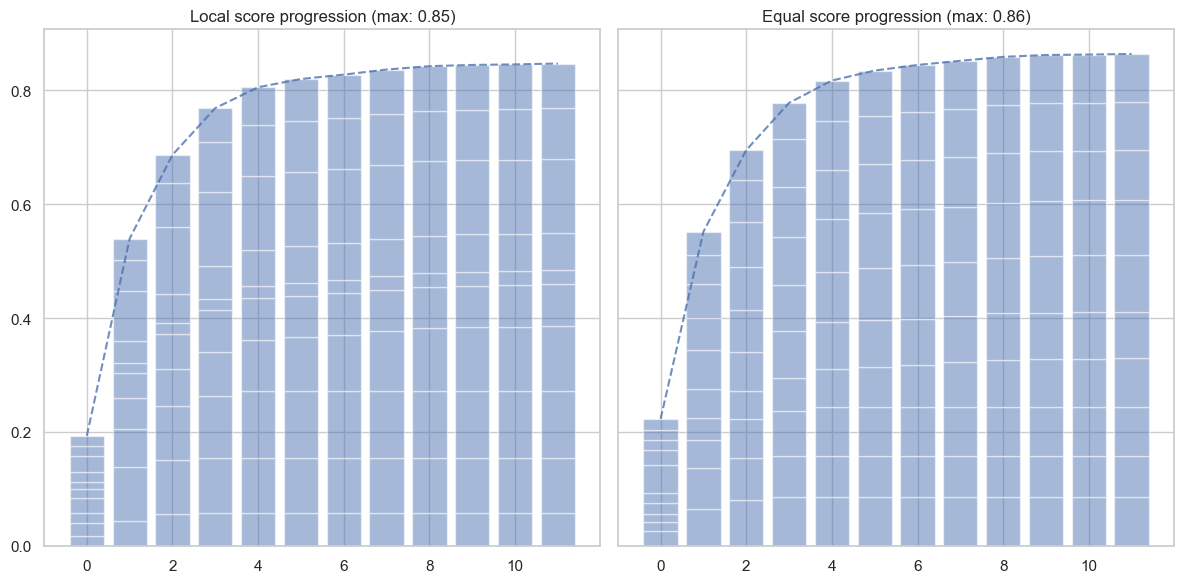

In [19]:
# setting an even higher threshold can be useful in complex datasets and benchmarks
# hitting a score = 1.0 in this case means that we cannot exclude the null hypothesis of
# the evaluated distribution having being generated from the same process as the one of interest
coverage_estimator.set_min_q(.95)

# initialize cell population to expand and score array
expanded_population, scores = np.copy(coverage_estimator.initial_points), np.zeros((12, len(coverage_estimator.subsets)))

for i in range(len(scores)):
    scores[i] = coverage_estimator.score(expanded_population, aggregate=False)
    expanded_population = sample_fn(expanded_population)

# plot scores
plot_scores(scores, (1,2), scopes=['Local', 'Equal'], max_score=True)

# Performance optimization

Although the cytobench library was implemented solely for demonstrative purposes and has undergone no optimization, using one of the local scopes (ie. "local" or "equal") will still cut out some of the redundant pairwise comparisons significantly accelerating runtimes for larger datasets. A properly coded version would eventually allow to entirely cut out global comparisons bounding the computational complexity to a linear scale even for extremely large datasets. This of course can be also achieved by first clustering the dataset and then running the validations for each cluster manually.

This approach enables prototyping large foundational models with a very efficient resource footprint. In this case, fine-tuning the leiden resolution parameter should be considered to validate the manifold volumes considered in the local distribution analysis.

In [22]:
%%time

# example runtime for a simulation on the global scope
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p = .1, n_iterations = 20, scope = 'global', min_dist_q = None)
    for i in range(5)
])

np.round(np.max(scores, axis=1), 2)

CPU times: user 17.7 s, sys: 969 ms, total: 18.7 s
Wall time: 16.4 s


array([0.57, 0.57, 0.68, 0.64, 0.6 ])

In [23]:
%%time

# example runtime for a simulation on the local scope
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p = .1, n_iterations = 20, scope = 'local', min_dist_q = None)
    for i in range(5)
])

np.round(np.max(scores, axis=1), 2)

CPU times: user 6.78 s, sys: 699 ms, total: 7.48 s
Wall time: 4.97 s


array([0.47, 0.47, 0.5 , 0.51, 0.52])

Using the minimum distance estimates furthermore adds to the computational complexity

In [24]:
%%time

# example runtime for a simulation with estimated minimum distances on the global scope
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p = .1, n_iterations = 20, scope = 'global', min_dist_q = .5)
    for i in range(5)
])

np.round(np.max(scores, axis=1), 2)

CPU times: user 36.2 s, sys: 1.35 s, total: 37.5 s
Wall time: 35.2 s


array([0.86, 0.79, 0.85, 0.62, 0.55])

In [25]:
%%time

# example runtime for a simulation with estimated minimum distances on the local scope
scores = np.array([
    cytobench.score_model(sample_fn, X[cells_mask], approx_p = .1, n_iterations = 20, scope = 'local', min_dist_q = .5)
    for i in range(5)
])

np.round(np.max(scores, axis=1), 2)

CPU times: user 9.65 s, sys: 742 ms, total: 10.4 s
Wall time: 7.85 s


array([0.6 , 0.6 , 0.61, 0.62, 0.61])